In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
!pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=1d87e8b2bd95f62b275c9c77d1a2f74e08a5ec2bfb8b115b3a22df8a2338bef8
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [8]:
%cd /content/gdrive/My Drive/CS6250

/content/gdrive/My Drive/CS6250


In [9]:
!python preprocessing1.py

In [10]:
!python preprocessing2.py

tcmalloc: large alloc 5134286848 bytes == 0x5b606000 @  0x7f74a3438001 0x7f74a0dc71af 0x7f74a0e1dc23 0x7f74a0e1ea87 0x7f74a0ec0823 0x58f62c 0x510bf2 0x58fd37 0x510325 0x5b4ee6 0x58ff2e 0x510325 0x4bac0a 0x4d3249 0x5917ee 0x591ac9 0x539167 0x50cb08 0x5b4ee6 0x6005a3 0x607796 0x60785c 0x60a436 0x64db82 0x64dd2e 0x7f74a3033c87 0x5b636a
tcmalloc: large alloc 5134286848 bytes == 0x18e42a000 @  0x7f74a34361e7 0x7f74a0dc70ce 0x7f74a0e21726 0x7f74a0e21b09 0x7f74a0e23620 0x7f74a0e23d1b 0x7f74a0ec4333 0x58f62c 0x510bf2 0x5b4ee6 0x6005a3 0x607796 0x60785c 0x60a436 0x64db82 0x64dd2e 0x7f74a3033c87 0x5b636a


In [11]:
!python preprocessing3.py

tcmalloc: large alloc 5134286848 bytes == 0x1f734000 @  0x7f88e9d8c1e7 0x7f88e76dd0ce 0x7f88e7734e57 0x7f88e7735a6f 0x7f88e77dbc5d 0x58f795 0x510bf2 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x6005a3 0x607796 0x60785c 0x60a436 0x64db82 0x64dd2e 0x7f88e9989c87 0x5b636a
preprocessing3.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array(data)


In [12]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import regularizers
import joblib
from sklearn.metrics import roc_auc_score

In [25]:
label_to_ix=np.load('label_to_ix.npy', allow_pickle=True).item()
ix_to_label=np.load('ix_to_label.npy', allow_pickle=True)
training_data=np.load('training_data.npy', allow_pickle=True)
test_data=np.load('test_data.npy', allow_pickle=True)
val_data=np.load('val_data.npy', allow_pickle=True)
word_to_ix=np.load('word_to_ix.npy', allow_pickle=True).item()
ix_to_word=np.load('ix_to_word.npy', allow_pickle=True)
newwikivec=np.load('newwikivec.npy', allow_pickle=True)

# CNN Base Model - Without wiki data

In [26]:
# Create the model:

EMBEDDING_SIZE = 100
hidden_dim=500
maxlen = 200
MAX_SEQ_LENGTH = 100
MAX_VOCAB = len(word_to_ix)
num_classes = len(label_to_ix)

def build_cnn_model(input_length, embedding_size, max_vocab, num_filters, filter_sizes, training_dropout_keep_prob, num_classes):
  model_input = Input(shape=input_length)
  z =  Embedding(max_vocab + 1, embedding_size,input_length=input_length, embeddings_regularizer=regularizers.l2(0.0001),name="embedding")(model_input)
  # Convolutional block
  conv_blocks = []
  for sz in filter_sizes:
      conv = Convolution1D(filters=num_filters,                         
                        kernel_size=sz,
                        padding="valid",
                        activation="relu",
                        strides=1)(z)
      window_pool_size =  input_length  - sz + 1 
      conv = MaxPooling1D(pool_size=window_pool_size)(conv)  
      conv = Flatten()(conv)
      conv_blocks.append(conv)
  #concatenate
  z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
  z = Dropout(training_dropout_keep_prob)(z)
  # z = Dense(hidden_dim, activation="relu")(z)
  model_output = Dense(num_classes, activation="sigmoid")(z)

  model = Model(model_input, model_output)
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  # print(model.summary())
  return model

In [27]:
cnn_model = build_cnn_model(input_length=MAX_SEQ_LENGTH, embedding_size=EMBEDDING_SIZE, max_vocab = MAX_VOCAB, num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.5, num_classes = num_classes)
print(cnn_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4796100     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 99, 100)      20100       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 98, 100)      30100       ['embedding[0][0]']              
                                                                                              

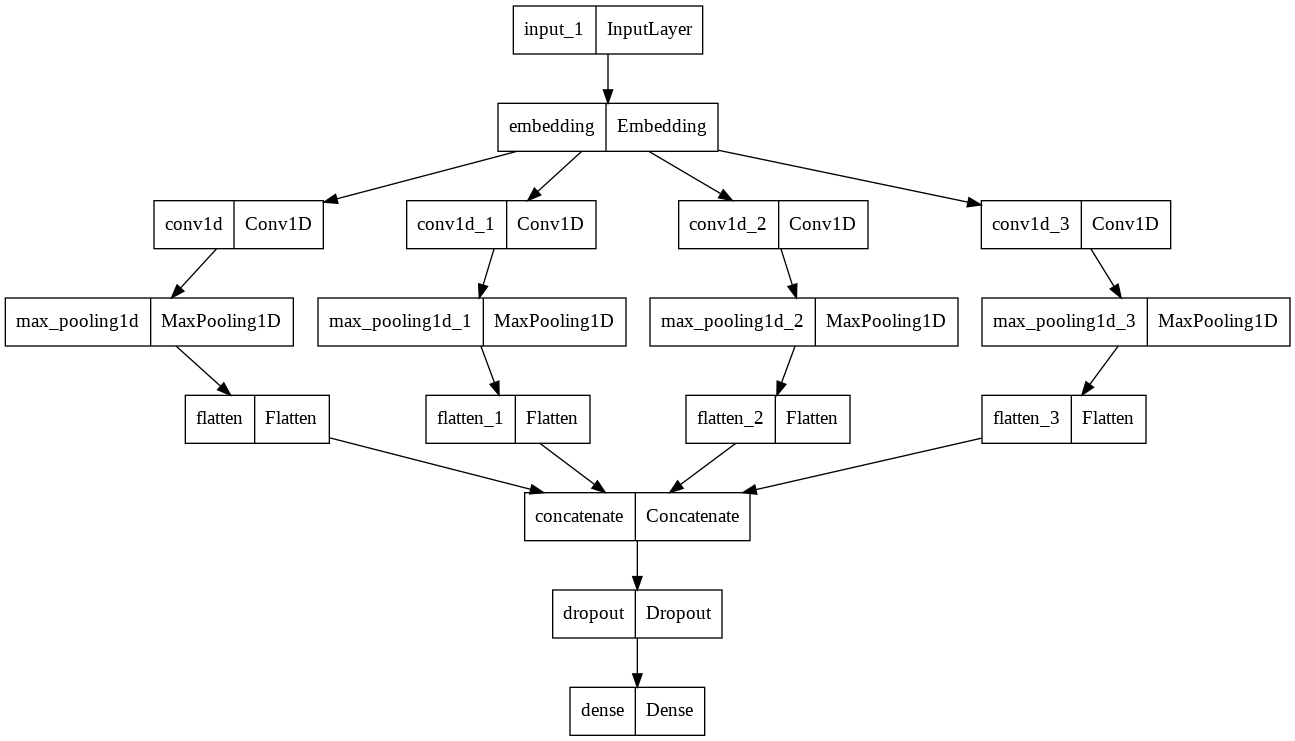

In [28]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(cnn_model,'cnn_base.png')
Image('cnn_base.png')

In [29]:
count = [len(x[0]) for x in training_data]

In [30]:
min(count), max(count), np.mean(count), np.median(count)

(36, 5285, 1023.7772870149578, 937.0)

In [31]:
def get_data(input_data):
  # training_data is of the form (list of list of words, notes, y )
  #training_data[0]
  #array([list(['admission', 'date', 'discharge', 'date', 'date', 
  #array([1., 1., 1., ..., 0., 0., 0.]),
       #list(['d_427', 'd_423', 'd_458', 'd_401', 'd_272', 'd_250', 'd_424'])],
  x_data =  [[word_to_ix[x] for x in record[0] if x in word_to_ix] for record in input_data]
  x_data = tf.keras.utils.pad_sequences(x_data, maxlen=MAX_SEQ_LENGTH, padding="post")
  y_data = [[label_to_ix[x] for x in record[2] if x in label_to_ix] for record in input_data]
  ylabel_count = np.array([len(item) for item in y_data])
  arg_zero = np.argwhere(ylabel_count == 0)
  y_data = [y_data[i] for i in range(len(y_data)) if i not in arg_zero]
  x_data = [x_data[i] for i in range(len(x_data)) if i not in arg_zero]
  x_data = np.array(x_data)
  for idx, item in enumerate(y_data):
    y = np.zeros(len(label_to_ix),)
    y[item] = 1
    y_data[idx] = y
  y_data = np.array(y_data)
  return x_data, y_data

In [32]:
train_x, train_y = get_data(training_data)

In [33]:
train_y.shape, train_x.shape
# ((34898, 344), (34898, 100))

((34898, 344), (34898, 100))

In [34]:
val_x, val_y = get_data(val_data)
test_x, test_y = get_data(test_data)

In [35]:
val_y.shape, val_x.shape, test_y.shape, test_x.shape

((5022, 344), (5022, 100), (9985, 344), (9985, 100))

In [37]:
def train_cnn_model(train_x, train_y, val_x, val_y, batch_size=50, epochs=20):
  tf.config.run_functions_eagerly(True) # https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
  cnn_model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=batch_size, epochs=epochs, verbose=2)
  # save model
  cnn_model.save('cnn_20_epochs.h5')

In [38]:
import os
path='cnn_20_epochs.h5'
isExist = os.path.exists(path)
isExist

True

In [39]:
from keras.models import load_model
if not isExist:
  train_cnn_model(train_x, train_y, val_x, val_y, batch_size=50, epochs=20)

model = load_model('cnn_20_epochs.h5')


In [40]:
#prediction for training data
pred_train = model.predict(train_x, batch_size=50)
pred_train

698/698 [==============================] - 10s 3ms/step


array([[8.8359997e-02, 8.0895163e-02, 2.4360046e-02, ..., 2.1747737e-06,
        2.1406283e-06, 7.8584453e-06],
       [4.8652310e-02, 6.2857583e-02, 2.9607890e-02, ..., 7.9555530e-06,
        2.0548507e-05, 4.2494539e-05],
       [1.2932104e-01, 5.9861518e-02, 9.2091955e-02, ..., 4.5271034e-04,
        8.5424748e-05, 1.3125289e-04],
       ...,
       [1.0112121e-01, 3.8563222e-02, 4.3329947e-02, ..., 1.5857505e-07,
        2.3101133e-07, 2.2548127e-06],
       [3.3289936e-01, 3.7336536e-02, 2.0883601e-02, ..., 5.0996462e-08,
        3.5507885e-08, 1.7881581e-08],
       [1.2974817e-01, 6.3494295e-02, 2.4965970e-02, ..., 1.1711512e-06,
        3.5246254e-07, 7.1492008e-07]], dtype=float32)

In [42]:
#prediction for validation data
pred_val = model.predict(val_x, batch_size=50)
pred_val

101/101 [==============================] - 0s 3ms/step


array([[3.71736996e-02, 4.90846671e-02, 1.24169067e-02, ...,
        5.63935885e-07, 1.41162445e-06, 1.53012797e-06],
       [9.75211710e-02, 5.10589480e-02, 3.74705531e-02, ...,
        9.29740793e-07, 4.05064071e-07, 8.80189589e-07],
       [4.49045897e-02, 1.27735743e-02, 1.10968053e-02, ...,
        1.30062074e-06, 1.00947615e-08, 7.38446104e-08],
       ...,
       [2.39437953e-01, 2.00167093e-02, 1.63610186e-02, ...,
        2.26660813e-06, 1.90587944e-05, 4.27796181e-07],
       [9.84622538e-02, 1.00760981e-01, 6.81679770e-02, ...,
        6.21455420e-09, 9.22303229e-07, 5.00359129e-05],
       [7.90906996e-02, 5.20869754e-02, 3.23939621e-02, ...,
        2.02497904e-06, 1.50716130e-06, 9.68164272e-07]], dtype=float32)

In [43]:
val_y.shape, pred_val.shape

((5022, 344), (5022, 344))

In [44]:
from sklearn.metrics import f1_score, roc_auc_score
def get_f1_score(y_actual, pred_val):
  y_final = np.where(np.array(pred_val) > 0.005, 1, 0)
  f1score_macro = f1_score(np.array(y_actual), y_final, average="macro")
  print(f"f1score_macro = {f1score_macro}")
  f1score_micro = f1_score(np.array(y_actual), y_final, average="micro")
  print(f"f1score_micro = {f1score_micro}")
  return f1score_macro, f1score_micro


In [94]:
# f1score_micro = f1_score(np.array(train_y), y_final, average="micro")
# f1score_micro

0.12242476441350231

In [45]:
#prediction for test data
pred_test = model.predict(test_x, batch_size=50)
pred_test

200/200 [==============================] - 1s 5ms/step


array([[1.2096068e-01, 7.9036050e-02, 6.6957697e-02, ..., 1.0511015e-04,
        6.2855383e-05, 1.2656349e-04],
       [1.0778839e-01, 4.5654058e-02, 2.9553035e-02, ..., 9.7962729e-06,
        2.5432888e-05, 2.3873004e-05],
       [2.3327362e-02, 1.5695073e-02, 6.3389488e-03, ..., 7.2486217e-09,
        2.2266369e-07, 1.1501872e-08],
       ...,
       [1.2220491e-02, 4.0246494e-02, 3.5727748e-03, ..., 4.2709097e-10,
        1.1134901e-09, 2.0631821e-10],
       [6.6872239e-02, 4.2521331e-02, 3.3049554e-02, ..., 1.4868567e-05,
        7.5642374e-06, 4.3117583e-05],
       [7.0669897e-02, 3.5411172e-02, 1.9006973e-02, ..., 2.6313171e-06,
        3.7400545e-07, 3.4870029e-06]], dtype=float32)

In [46]:
f1score_macro, f1score_micro = get_f1_score(val_y, pred_val)
f1score_macro, f1score_micro

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


f1score_macro = 0.04053318340667131
f1score_micro = 0.11940493877257168


(0.04053318340667131, 0.11940493877257168)

In [47]:
f1score_test_macro, f1score_test_micro = get_f1_score(test_y, pred_test)
f1score_test_macro, f1score_test_micro

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


f1score_macro = 0.04019574201150448
f1score_micro = 0.12019259152361146


(0.04019574201150448, 0.12019259152361146)

In [48]:
y_final = np.where(np.array(pred_val) > 0.005, 1, 0)
print(len(np.unique(y_final)))
print(len(np.unique(val_y)))
# auc_macro = roc_auc_score(val_y, y_final, average="macro", multi_class="ovo")
# print(f"auc_macro = {auc_macro}")
auc_micro = roc_auc_score(val_y, y_final, average="micro")
print(f"auc_micro = {auc_micro}")

2
2
auc_micro = 0.8625718730269162


In [49]:
y_final_test = np.where(np.array(pred_test) > 0.005, 1, 0)
print(len(np.unique(y_final_test)))
print(len(np.unique(test_y)))
# auc_macro = roc_auc_score(test_y, y_final_test, average="macro", multi_class="ovo")
# print(f"auc_macro = {auc_macro}")
auc_micro = roc_auc_score(test_y, y_final_test, average="micro")
print(f"auc_micro = {auc_micro}")

2
2
auc_micro = 0.8610052517112216


# Models from Original Paper

In [8]:
!python KSI_CNN.py

KSI_CNN.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_CNN.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.447759546015512
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validati

In [10]:
!python KSI_LSTM.py

KSI_LSTM.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_LSTM.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.4288319600440542
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
valid

In [ ]:
!python KSI_LSTMatt.py

KSI_LSTMatt.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_LSTMatt.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.3796880833045024
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [ ]:
!python KSI_CAML.py

KSI_CAML.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_CAML.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.6044048484082241
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
valid